# EID 444 Homework 4

# Modified Displacement Function (w/ Shift function))

In [217]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
import time


#[1] https://stackoverflow.com/questions/29241056/how-do-i-use-np-newaxis

#R is a matrix of particle positions for N L-J particles

def shift(R, L):
    '''Adding periodic boundary conditions'''
    R = R - np.round(R/L) * L
    return R

def displacements(R, L):
    '''Calculates all displacements between all pairs 
    of particles'''

    #Wrapping positions under periodic boundary conditions
    R_wrapped = shift(R,L)

    #Computes the pairwise displacements: r_i - r_j
    #[1] - Learned about np.newaxis to help conduct matrix operations without consuming much memory
    dR = R[:, np.newaxis, :] - R[np.newaxis, :, :]
    dR_wrapped = R_wrapped[:, np.newaxis, :] - R_wrapped[np.newaxis, :, :]
 
    return dR, dR_wrapped


# LJ Forces Function

In [218]:
def lj_forces(dR, sigma, epsilon):

     rij = np.linalg.norm(dR, axis=-1)
     FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation
     FRR[np.isnan(FRR)] = 0 #Shown to me by Jared

     return FRR


# Net Forces

In [219]:
def net_forces(FRR):
    FR = np.nansum(FRR, axis=1) #Shown to me by Jared. Had an issue where I could not get rid of nan values
    return FR

# Verlet Step

In [220]:
def verlet_step(r_current, r_prev, t, m, FR):
    """ Calculate the Verlet step of the Leonard-Jones particle system. """

    acceleration = FR / m[:, np.newaxis]  

    r_next = (2 * r_current) - r_prev + (acceleration * (t**2))

    return r_next 



# Simulation

In [221]:
#Credit to Jared for telling me to create a function that combines all previous functions


def Force_from_displacement(R, sigma, epsilon, L):
    dR, dR_wrapped = displacements(R, L)
    Forces = lj_forces(dR, sigma, epsilon)
    net_force = np.nansum(Forces[..., np.newaxis] * dR, axis=0) 
    net_force[np.isnan(net_force)] = 0
    return net_force


def simulation(R_0, v_0, m, t, t_max, sigma, epsilon, L):
    t_start = time.time()


    n_steps = int(t_max / t)
    N = len(R_0)

    #Initialize trajectory correctly as a NumPy array
    trajectory = np.zeros((n_steps, N, 2))

    #Set initial positions
    trajectory[0] = R_0
    trajectory[1] = R_0 + v_0 * t  # First Verlet step

    for step in range(1, n_steps - 1):
        #Compute forces
        FR = Force_from_displacement(trajectory[step], sigma, epsilon, L)
        
        #Compute next position using Verlet integration
        r_next = verlet_step(trajectory[step], trajectory[step - 1], t, m, FR)
        
        #Store new positions
        trajectory[step + 1] = r_next

    t_end = time.time()
    t_sim = t_end - t_start

    return trajectory, t_sim


# Plot and Animate Trajectory

In [222]:
def plot_traj(trajectory, L):

    trajectory = np.array(trajectory)  
    #trajectory = shift(trajectory, L)

    N = trajectory.shape[1] 

    for i in range(N):
        plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], marker='.')

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Particle Trajectories")
    plt.axis("equal")
    plt.show()


def animate_trajectory(trajectory, L,  interval=50, stride = 5, title = 'Leonard-Jones Particle Simulation'):

    trajectory = np.array(trajectory)
    trajectory = shift(trajectory, L) 
    n_steps, N, _ = trajectory.shape 

    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    ax.set_xlim(np.min(trajectory[..., 0]), np.max(trajectory[..., 0]))
    ax.set_ylim(np.min(trajectory[..., 1]), np.max(trajectory[..., 1]))
    ax.set_title(title)
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")

    #Initialize scatter plot
    scat = ax.scatter([], [], s=100)


    #[2] https://stackoverflow.com/questions/26892392/how-to-use-funcanimation-to-display-one-scatter-marker-per-frame
    def init():
        """Initialize animation frame with empty data."""
        scat.set_offsets(np.zeros((N, 2)))  # Set initial positions as empty
        return scat,

    def update(frame):
        """Update scatter plot for each frame."""
        positions = trajectory[frame] 
        scat.set_offsets(positions)  # Update particle positions
        return scat,

    #Create animation
    ani = animation.FuncAnimation(fig, update, frames=range(0, n_steps, stride), init_func=init, interval=interval, blit=True)
    ani.save('trajectory.gif', writer='pillow')

    return HTML(ani.to_jshtml())



# Create Triangular Lattice

In [223]:
def make_triangular_lattice(origin, N, lattice_constant):
  lattice = np.zeros((N*N,2))
  for i in range(N):
    for j in range(N):
      lattice[i*N + j] = origin + i*np.array([1,0]) + j*np.array([0.5, np.sqrt(3/4)])

  lattice = lattice_constant*(lattice - np.mean(lattice, axis = 0))
  return lattice

# Execution Time Function and Plot

In [224]:
#Calculate avergae simulation time
def calculate_tsim(N):
    tsim_avg = np.zeros(len(N))   
    tsim_errors = np.zeros(len(N))

    for step, N_val in enumerate(N):
        masses = np.ones(N_val * N_val)  
        L = N_val * (2**(1/6))  

        positions = shift(make_triangular_lattice(np.array([0,0]), N_val, 2**(1/6)), L)

        np.random.seed(20)
        v_max = 2
        velocities = v_max * 2 * (np.random.rand(N_val * N_val, 2) - 0.5) 

        t_sim_N = np.zeros(5)

        for i in range(5):  # Run 5 simulations per N_val
            _ , t_sim = simulation(R_0=positions, v_0=velocities, m=masses, 
                                     t=0.01, t_max=10, sigma=1, epsilon=1, L=L)
            t_sim_N[i] = t_sim

        # Compute statistics
        tsim_avg[step] = np.mean(t_sim_N)
        tsim_errors[step] = np.std(t_sim_N) / np.sqrt(5)  # Standard error

    return tsim_avg, tsim_errors

#Plot execution time vs system size
def plot_tsim_vs_N(N, tsim_avg, tsim_errors):
    plt.figure(figsize=(10,10))
    plt.errorbar(N, tsim_avg, yerr=tsim_errors, capsize=5)
    plt.plot(N, tsim_avg)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Lattice Size')
    plt.ylabel('t_simulation')
    plt.title('Execution Time vs System Size')
    plt.show()


# Calculate Momentum, KE, PE, and Total Energy

In [225]:
def calc_momentum(trajectory, masses, t):
    velocities = (trajectory[2:] - trajectory[:-2]) / (2*t)  #Central differencing
    print(velocities)
    momentum = masses[np.newaxis, :, np.newaxis] * velocities
    print(momentum)
    total_momentum = np.sum(momentum, axis=1)  
    return total_momentum 

def plot_momentum(total_momentum):
    plt.figure(figsize=(6,6))
    plt.scatter(total_momentum[:, 0], total_momentum[:, 1], color='orange')
    plt.xlabel("p_x")
    plt.ylabel("p_y")
    plt.title("Momentum Conservation Scatter Plot")
    plt.grid()
    plt.show()

def calc_KE(trajectory, masses, t):
    velocities = (trajectory[2:] - trajectory[:-2]) / (2*t)  
    kinetic_energy = 0.5 * masses[np.newaxis, :] * np.sum(velocities**2, axis=2)
    total_KE = np.sum(kinetic_energy, axis=1)
    return total_KE

#Potential is for L-J particles
def calc_PE(trajectory, sigma, epsilon):
    n_steps, N, _ = trajectory.shape
    PE = np.zeros(n_steps)

    for step in range(n_steps):
        R = trajectory[step]
        dR, _ = displacements(R, L)
        rij = np.linalg.norm(dR, axis=-1)
        U = 4 * epsilon * ((sigma / rij) ** 12 - (sigma / rij) ** 6)
        U[np.isnan(U)] = 0
        PE[step] = np.nansum(U) / 2 #Avoid double counting
        
    return PE

def plot_energies(KE, PE):

    time_steps = np.arange(len(KE))

    total_energy = KE + PE[1:-1] #Makes both variables the same shape
    plt.figure(figsize=(8, 5))
    plt.plot(time_steps, KE, label="Kinetic Energy", color="blue")
    plt.plot(time_steps, PE[1:-1], label="Potential Energy", color="red")
    plt.plot(time_steps, total_energy, label="Total Energy", color="black", linestyle="dashed")
    plt.xlabel("Time Step")
    plt.ylabel("Energy")
    plt.title("Energy Conservation")
    plt.legend()
    plt.grid()
    plt.show()


# Question 1 - Create Functions (Create Unit Vectors, Temp Calc, MB Distribution and Speed Distribution)

In [ ]:
def create_unit_vectors(N, seed):
    '''Creates an array of unit vectors for the velocities, gives it its direction'''
    #Initialize seed
    np.random.seed(seed)
    vectors_polar = np.random.uniform(0, 2*np.pi, N)
    #angles = np.linspace(0 + vectors_polar, 2*np.pi + vectors_polar, N, endpoint = False)
    unit_vectors = np.column_stack([np.cos(vectors_polar), np.sin(vectors_polar)])
    return unit_vectors


k_b = 1.0

def calc_temp(trajectory, t):
    ''' Calculates temperature at each frame of trajectory - essentially the average KE'''
    particle = len(trajectory[1])
    masses = np.ones(particle)
    KE = calc_KE(trajectory, masses, t)
    Temperature = 2 * (KE/particle) / (particle * k_b) # double check if right
    return Temperature

def MB_distribution(Temp, v_max, dv):
    'Plots 2D Maxwell-Boltzmann Distribution '


    v_list = np.arange(0, v_max, dv)

    #2D Maxwell-Boltzmann - m = 1
    MB_dist = ((v_list) /(k_b * Temp)) * np.exp (-v_list**2 / (2 * k_b * Temp))

    plt.plot(v_list, MB_dist, 'k--', label = 'Maxwell-Boltzmann')
    plt.xlabel('Speed')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

def speed_distribution(trajectory, dt, t_0, v_max, dv):
    velocities = (trajectory[2:] - trajectory[:-2]) / (2*dt) 
    speeds = np.linalg.norm(velocities[t_0:], axis=-1).flatten()

    bins = np.arange(0, v_max+dv, dv)
    plt.hist(speeds, bins=bins, density = True, label="Speed Distribution")

    plt.xlabel('Speed')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()






# Question 2

In [227]:
#plt.scatter(make_triangular_lattice(np.array([0,0]), 10, 2**(1/6))[:, 0], make_triangular_lattice(np.array([0,0]), 10, 2**(1/6))[:,1])

N = 10
masses = np.ones(N*N)

L = (N) * (2**(1/6))

positions = shift(make_triangular_lattice(np.array([0,0]), N, 2**(1/6)), L)
v_init = 2.0
velocities = v_init * create_unit_vectors(N*N, 20)
dt = 0.01

trajectory, _ =simulation(R_0 = positions, v_0 = velocities, m = masses, t=dt, t_max=10, sigma=1, epsilon = 1, L=L )

C:\Users\mo241\AppData\Local\Temp\ipykernel_23436\4205053979.py:4: RuntimeWarning: divide by zero encountered in divide
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation
C:\Users\mo241\AppData\Local\Temp\ipykernel_23436\4205053979.py:4: RuntimeWarning: invalid value encountered in add
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation


In [ ]:
N = 10
masses = np.ones(N*N)

L = (N) * (2**(1/6))

positions = shift(make_triangular_lattice(np.array([0,0]), N, 2**(1/6)), L)
v_init_values = np.arange(0.5, 4.5, 0.5)

dt = 0.01

trajectories = {}
t_simulation = {}

for v_init in v_init_values:
    velocities = v_init * create_unit_vectors(N*N, 20)
    trajectory, t_sim = simulation(R_0 = positions, v_0 = velocities, m = masses, t=dt, t_max=10, sigma=1, epsilon = 1, L=L )
    trajectories[v_init] = trajectory
    t_simulation[v_init] = t_sim

C:\Users\mo241\AppData\Local\Temp\ipykernel_23436\4205053979.py:4: RuntimeWarning: divide by zero encountered in divide
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation
C:\Users\mo241\AppData\Local\Temp\ipykernel_23436\4205053979.py:4: RuntimeWarning: invalid value encountered in add
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation


# Question 3

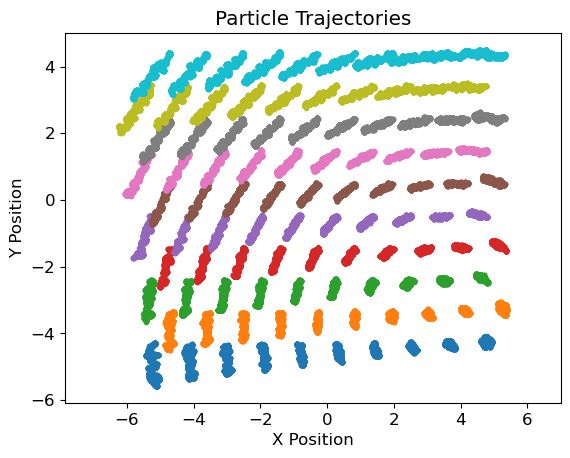

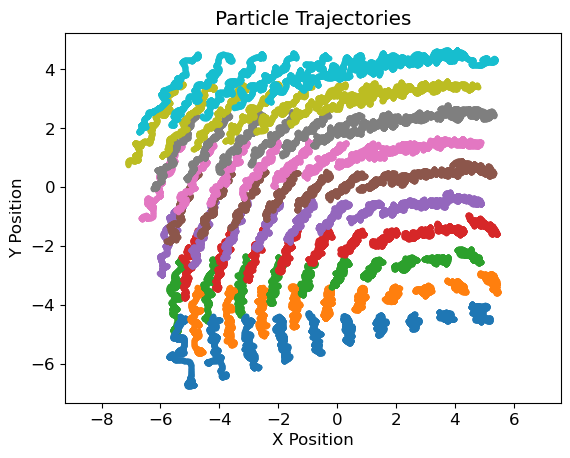

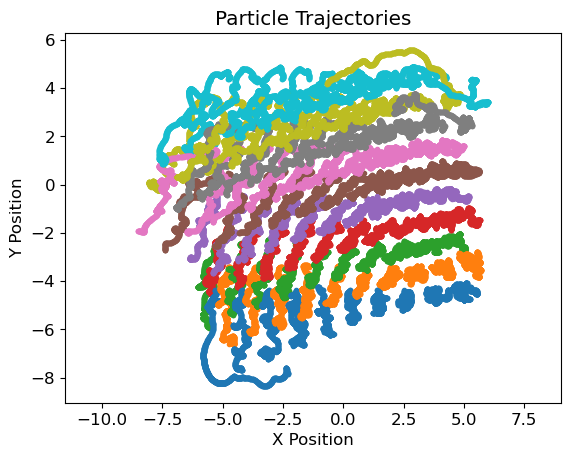

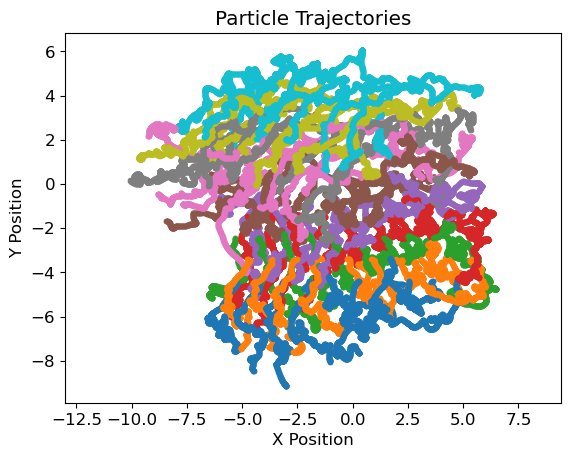

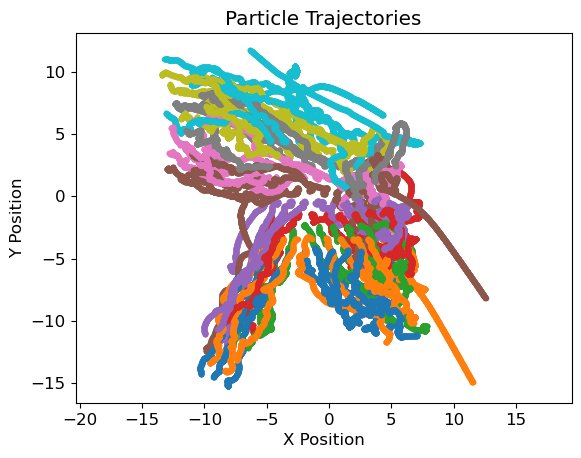

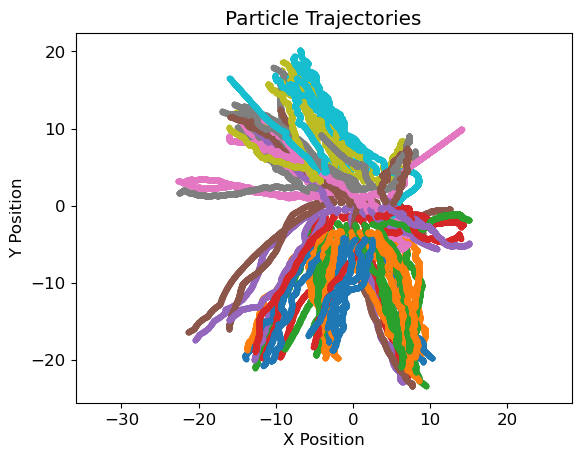

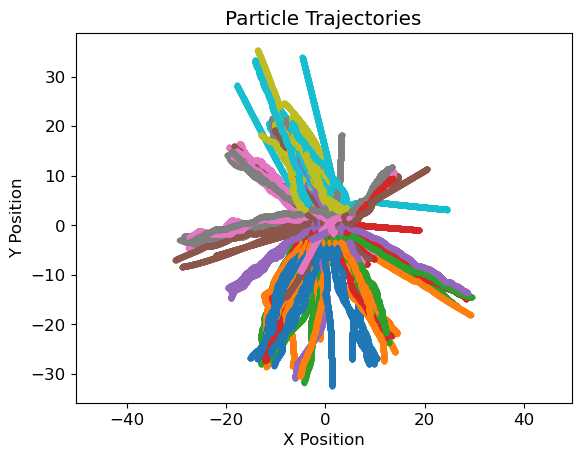

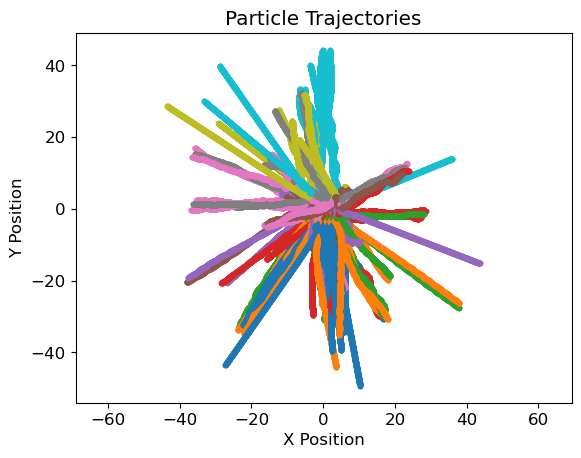

In [229]:
for trajectory in trajectories.values():
    plot_traj(trajectory, L)




KeyboardInterrupt: 

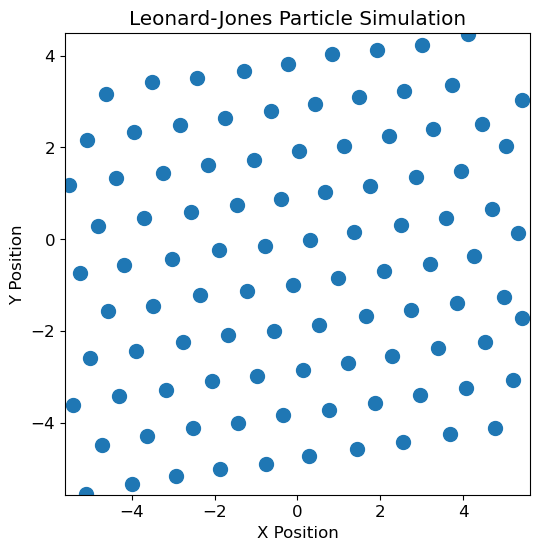

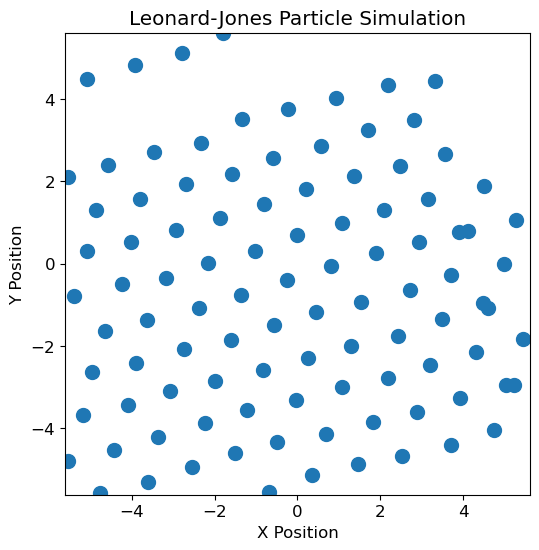

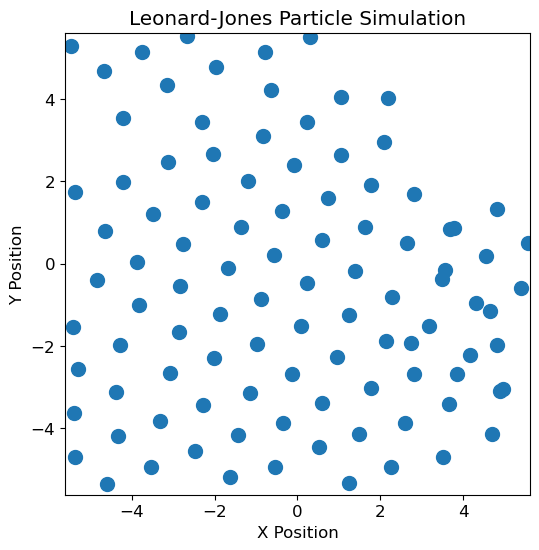

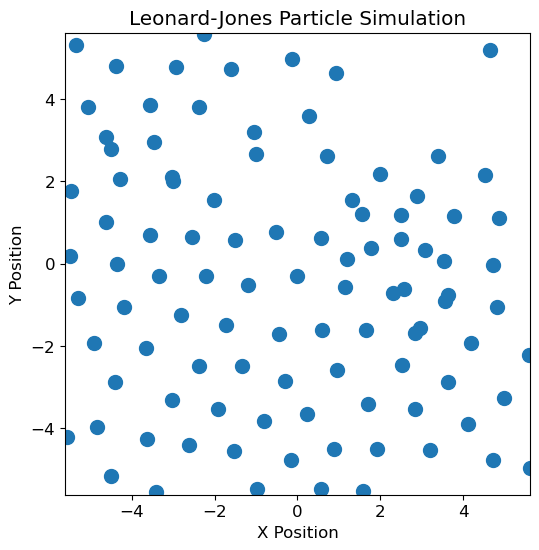

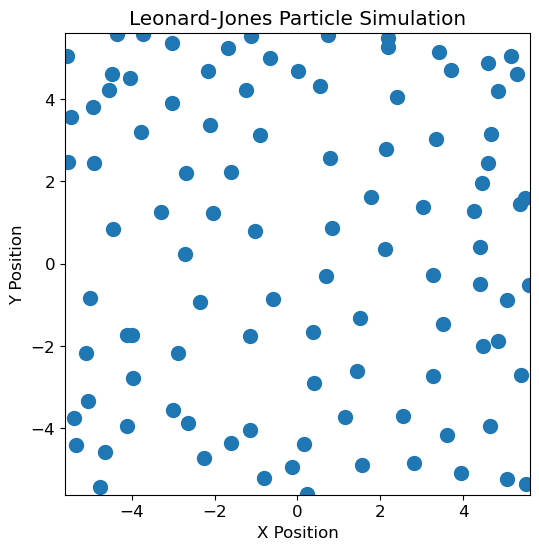

In [232]:
for trajectory in trajectories.values():
    animate_trajectory(trajectory, L)

# Question 4

Enter Response Here


# Question 5

In [ ]:
def plot_Temp_vs_tsim():
    '''Plotting the Temperature vs simulation time'''
    